#  **Import Necessary Libraries**

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import keras_tuner as kt
from keras_tuner.tuners import RandomSearch

import warnings
warnings.filterwarnings("ignore")

# **Load the Dataset**

In [2]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = 10000)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# **Sentiment and Label Distribution**

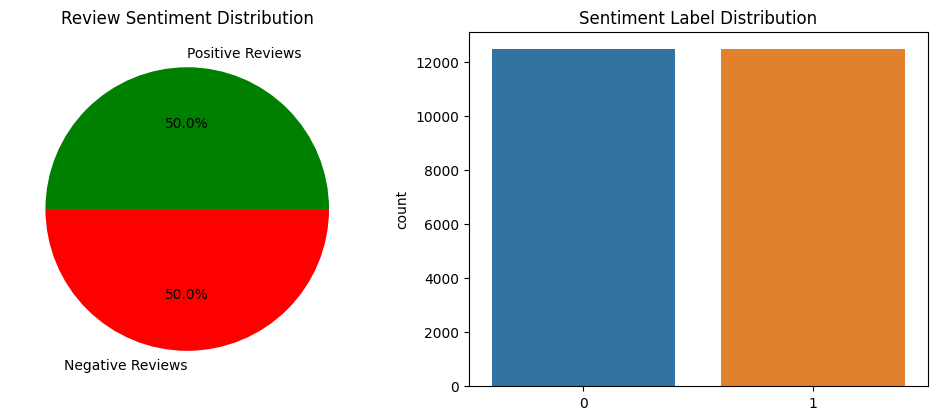

In [3]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
positive_count = np.sum(y_train == 1)
negative_count = np.sum(y_train == 0)
plt.pie([positive_count, negative_count], 
        labels=['Positive Reviews', 'Negative Reviews'], 
        autopct='%1.1f%%',
        colors=['green', 'red'])
plt.title('Review Sentiment Distribution')

plt.subplot(2, 2, 2)
sns.countplot(x=y_train)
plt.title('Sentiment Label Distribution')

plt.tight_layout()
plt.show()

***Sentiment and Review are perfectly distributed, half and half*** 😅

# **pad_sequences**

In [4]:
max_len=100
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

# **Building Model**

In [5]:
def build_model(hyperparam):
    model = Sequential()
    
    model.add(Embedding(input_dim=10000, 
              output_dim=hyperparam.Int("embedding_output", min_value=64, max_value=300, step=32), 
              input_length=max_len, embeddings_regularizer=l2(1e-4)))
    
    model.add(SimpleRNN(units=hyperparam.Int("rnn_units_1", min_value=64, max_value=256, step=32), return_sequences=True))
    model.add(SimpleRNN(units=hyperparam.Int("rnn_units_2", min_value=32, max_value=128, step=32)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hyperparam.Float("dropout_rate", min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(64, activation="relu", 
                   kernel_regularizer=l2(hyperparam.Float("l2_reg", min_value=1e-4, max_value=1e-2, step=1e-4))))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer=hyperparam.Choice("optimizer", ["adam", "rmsprop"]),
                 loss="binary_crossentropy", metrics=["accuracy", "AUC", keras.metrics.Precision(), keras.metrics.Recall()])
    return model

## **RandomSearch**

In [6]:
tuner = RandomSearch(build_model, objective= "val_accuracy", max_trials=5, executions_per_trial=2,
                    directory="rnn_tuner_directory", project_name="imdb_rnn")

## **EarlyStopping**

In [7]:
early_stopping = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

##  **ReduceLROnPlateau**

* ***Dynamically reduces learning rate during training***
* ***Decreases learning rate when performance improves***
* ***Helps the model learn more precisely***
* ***Tries to escape from local minima***

In [8]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

In [9]:
tuner.search(x_train, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Trial 5 Complete [00h 12m 56s]
val_accuracy: 0.6553000211715698

Best val_accuracy So Far: 0.8157999813556671
Total elapsed time: 01h 02m 10s


## **Best Model**

In [10]:
best_model = tuner.get_best_models(num_models=1)[0]

In [11]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (32, 100, 192)              │       1,920,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (32, 100, 64)               │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (32, 32)                    │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (32, 32)                    │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 32)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 1)                     │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,941,857 (7.41 MB)

 Trainable params: 1,941,793 (7.41 MB)

 Non-trainable params: 64 (256.00 B)

# **Result of the Best Model**

## **loss, compile_metrics Values** 

In [12]:
results = best_model.evaluate(x_test, y_test)
print("Test Metrics:")
for metric_name, value in zip(best_model.metrics_names, results):
    print(f"{metric_name}: {value:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - AUC: 0.8971 - accuracy: 0.8120 - loss: 0.5177 - precision: 0.8471 - recall: 0.7543
Test Metrics:
loss: 0.5124
compile_metrics: 0.8160


## **classification_report**

In [13]:
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

print(classification_report(y_test, y_pred))

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
              precision    recall  f1-score   support

           0       0.78      0.87      0.83     12500
           1       0.86      0.76      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



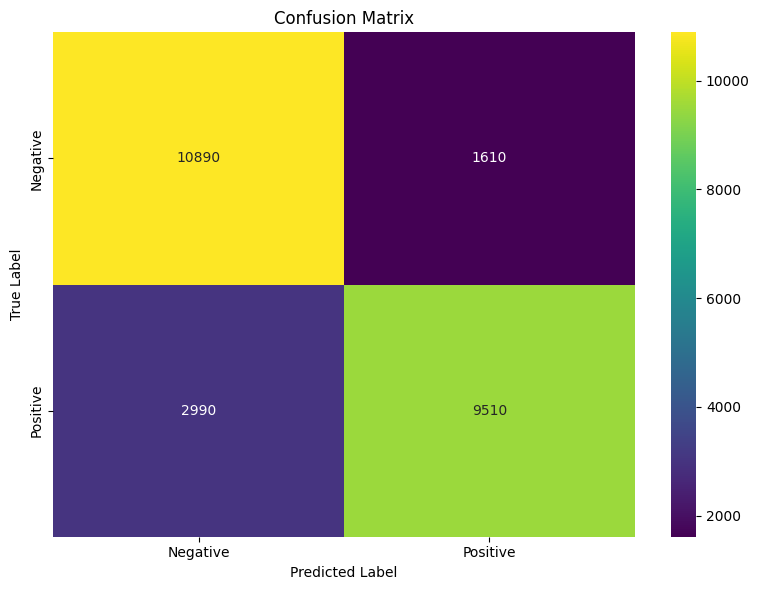

In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## **Receiver Operating Characteristic (ROC) Curve**

In [15]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

roc_curve = auc(fpr, tpr)

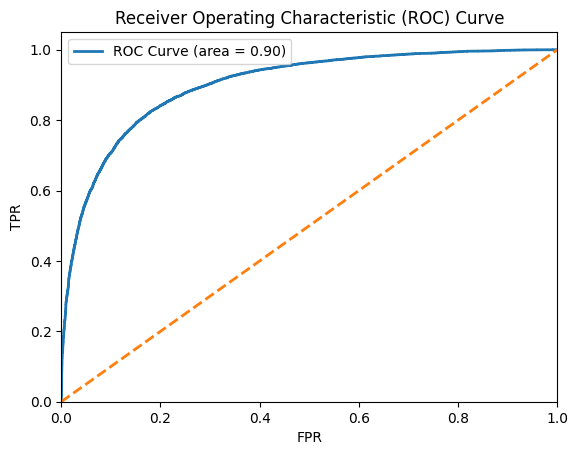

In [16]:
plt.figure()
plt.plot(fpr, tpr, lw=2, label="ROC Curve (area = %0.2f)" % roc_curve)
plt.plot([0,1],[0,1],  lw=2, linestyle="--")
plt.xlim([0,1])
plt.ylim([0, 1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

# **Load the Dataset for LSTM**

***I wanted to use imdb's raw dataset to use Tokenizer***

In [18]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('imdb_reviews', as_supervised=True, with_info=True)

# **Get Raw Texts and Labels**

In [19]:
x = []
y = []

for text, label, in dataset['train']:
    x.append(text.numpy().decode('utf-8')) # Get text as string
    y.append(label.numpy()) # Label (0: Negative, 1: Positive)

# **Create Tokenizer**

In [20]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>') # OOV = token for unknown words
tokenizer.fit_on_texts(x)

***OOV = token for unknown words***

# **Convert text to numeric**

In [21]:
x_sequences = tokenizer.texts_to_sequences(x)

# **Pad sequences**

In [22]:
max_len = 100
x_padded = pad_sequences(x_sequences, maxlen=max_len, padding="post", truncating="post")

##  **Label Encoding**

In [23]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

##  **train-test split**

In [24]:
x_train_lstm, x_test_lstm, y_train_lstm, y_test_lstm = train_test_split(x_padded, y_encoded, test_size=0.2, random_state=42)

##  **Build LSTM Model**

In [25]:
def build_lstm_model():
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128, input_length=100),
        LSTM(units=128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
        LSTM(units=64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer="adam",
                  loss='binary_crossentropy',
                  metrics=['accuracy',  keras.metrics.Precision(), keras.metrics.Recall()])
    
    return model

In [26]:
lstm_model = build_lstm_model()

##  **EarlyStopping for LSTM**

In [27]:
early_stopping = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

In [28]:
history = lstm_model.fit(x_train_lstm, y_train_lstm, epochs=20, batch_size=64,
                   validation_split=0.1, callbacks=[early_stopping])

Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 73s 237ms/step - accuracy: 0.5361 - loss: 0.7003 - precision_1: 0.5424 - recall_1: 0.5209 - val_accuracy: 0.6785 - val_loss: 0.6018 - val_precision_1: 0.6150 - val_recall_1: 0.9713
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 66s 236ms/step - accuracy: 0.6257 - loss: 0.6361 - precision_1: 0.6093 - recall_1: 0.7334 - val_accuracy: 0.5260 - val_loss: 0.6860 - val_precision_1: 0.5160 - val_recall_1: 0.9901
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 66s 234ms/step - accuracy: 0.5221 - loss: 0.6853 - precision_1: 0.5229 - recall_1: 0.6749 - val_accuracy: 0.6190 - val_loss: 0.6839 - val_precision_1: 0.7131 - val_recall_1: 0.4109
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 67s 236ms/step - accuracy: 0.5649 - loss: 0.6752 - precision_1: 0.5534 - recall_1: 0.7013 - val_accuracy: 0.5100 - val_loss: 0.6987 - val_precision_1: 0.5075 - val_recall_1: 1.0000
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 66s 233ms/step - accuracy: 0.5703 - loss: 0.6733 - precision_1: 0.5823 - rec

In [29]:
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,402,309 (16.79 MB)

 Trainable params: 1,467,393 (5.60 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 2,934,788 (11.20 MB)

##  **Result of the LSTM Model**

In [30]:
results = lstm_model.evaluate(x_test_lstm, y_test_lstm, verbose=1)
print("Metrics:")
for metric_name, metric_value in zip(lstm_model.metrics_names, results):
    print(f"{metric_name}: {metric_value:.3f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.8124 - loss: 0.4451 - precision_1: 0.7760 - recall_1: 0.8705
Metrics:
loss: 0.431
compile_metrics: 0.815


In [31]:
y_pred_prob_lstm = lstm_model.predict(x_test_lstm)
y_pred_lstm = np.argmax(y_pred_prob_lstm, axis=1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step


##  **Training & Validation Loss and Accuracy**

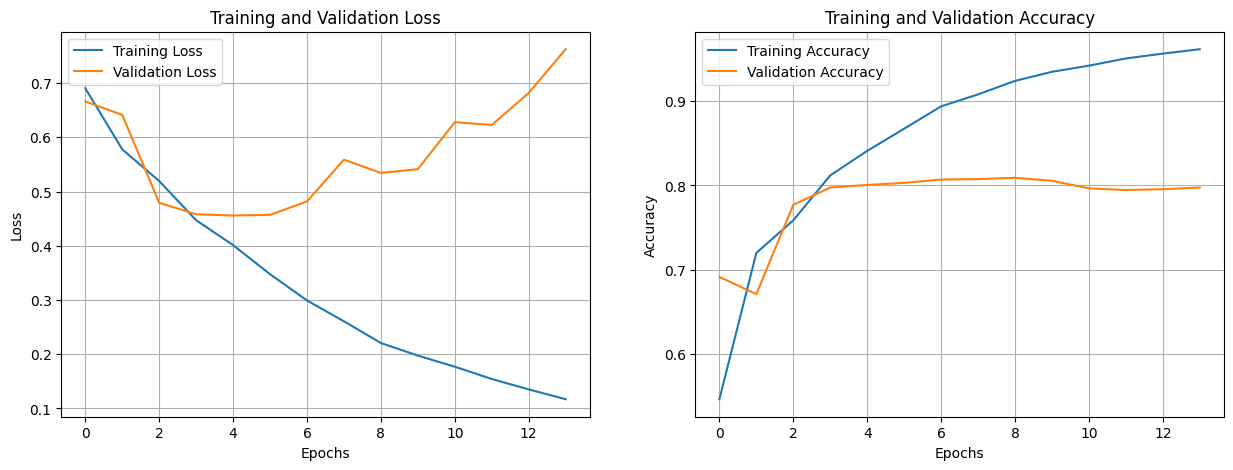

In [32]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid("True")

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid("True")

##  **Receiver Operating Characteristic (ROC) Curve for LSTM**

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step


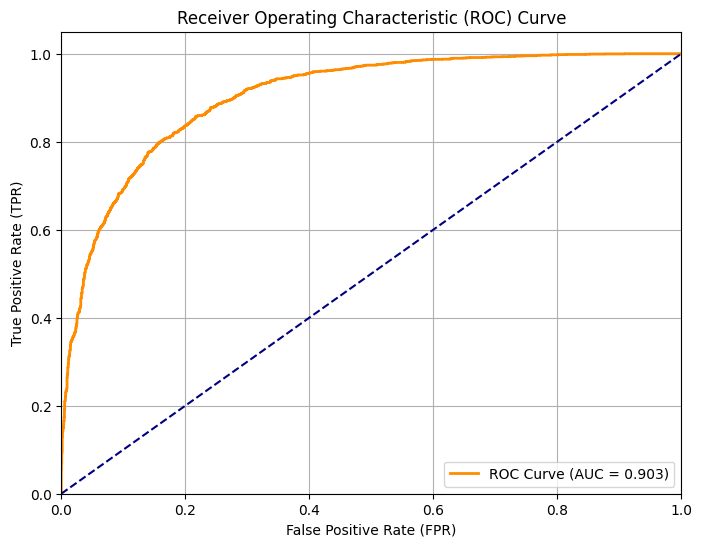

In [34]:
y_pred_probs = lstm_model.predict(x_test_lstm)

if y_pred_prob_lstm.shape[1] > 1:
    y_pred_prob_lstm = y_pred_prob_lstm[:, 1]

fpr, tpr, _ = roc_curve(y_test_lstm, y_pred_prob_lstm)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--") 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# **Conclusion**

***I builded RNN and LSTM models using movie comments on the IMDB. First I did a simple exploratory data analysis (EDA) to understand the distributions and the dataset. I did hyperparameter tuning and RandomSearch to find the best parameters and model for RNN. The imdb dataset in Keras is already in numerical form. But for LSTM I downloaded the imdb dataset from tensorflow and used it to use the raw comments and dataset.***